In [1]:
import numpy as np 
import pandas as pd 
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as  tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
x_train = np.load('./npy_covid64/x_train.npy')
y_train = np.load('./npy_covid64/y_train.npy')
x_test=np.load('./npy_covid64/x_test.npy')
y_test=np.load('./npy_covid64/y_test.npy')

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
print(x_train[0].shape)
print(x_train.shape[1:])

(64, 64)
(64, 64)


In [5]:
# bulid model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 128)           98816     
_________________________________________________________________
dropout (Dropout)            (None, 64, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6

In [7]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

In [8]:
model.compile(loss='binary_crossentropy', optimizer=opt,
             metrics=['accuracy'])

In [9]:
start = time.time() # Measuring the processing time
history=model.fit(x_train, y_train, epochs=5,validation_data=(x_test, y_test) )#validation_split=0.3)
end = time.time()
print(end - start)

Epoch 1/5
363/363 [==============================] - 36s 99ms/step - loss: 0.7015 - accuracy: 0.5304 - val_loss: 0.6813 - val_accuracy: 0.5231
Epoch 2/5
363/363 [==============================] - 39s 107ms/step - loss: 1.9653 - accuracy: 0.6797 - val_loss: 7.4833 - val_accuracy: 0.5121
Epoch 3/5
363/363 [==============================] - 38s 104ms/step - loss: 7.4516 - accuracy: 0.5141 - val_loss: 7.4833 - val_accuracy: 0.5121
Epoch 4/5
363/363 [==============================] - 38s 103ms/step - loss: 7.5085 - accuracy: 0.5104 - val_loss: 7.4833 - val_accuracy: 0.5121
Epoch 5/5
363/363 [==============================] - 36s 101ms/step - loss: 7.4716 - accuracy: 0.5128 - val_loss: 7.4833 - val_accuracy: 0.5121
189.25983428955078


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [11]:
#                      EVALUATE TRAINED MODEL
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7.4833149909973145
Test accuracy: 0.512077271938324


In [12]:
from keras import metrics
from sklearn.metrics import confusion_matrix

In [13]:
pred = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [14]:
confusion_matrix(pred, np.argmax(y_test,axis =1))

array([[1342, 1374],
       [  40,  142]], dtype=int64)

In [15]:
import seaborn as sns

In [16]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['No Covid','Covid'])
    df_cm2.columns=['No Covid','Covid']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()    
    return

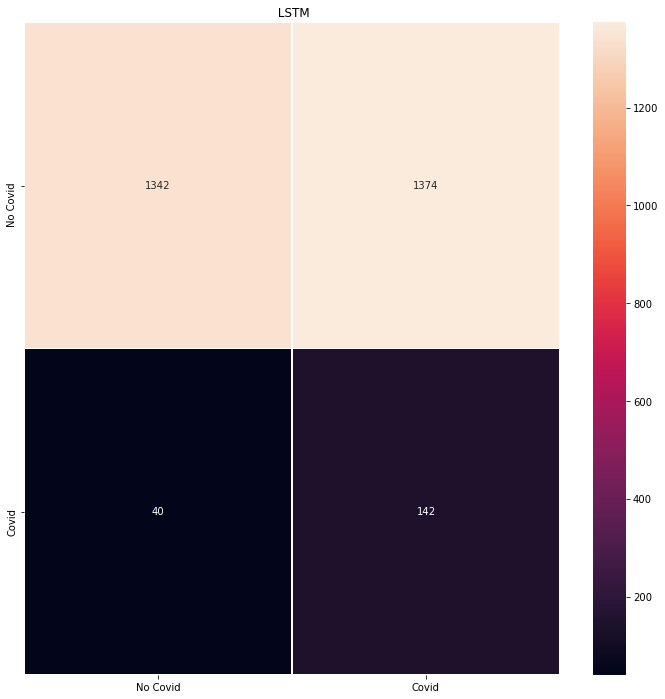

In [17]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),' LSTM')

In [18]:
from sklearn.metrics import classification_report
print(classification_report(pred, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9711    0.4941    0.6550      2716
           1     0.0937    0.7802    0.1673       182

    accuracy                         0.5121      2898
   macro avg     0.5324    0.6372    0.4111      2898
weighted avg     0.9160    0.5121    0.6243      2898



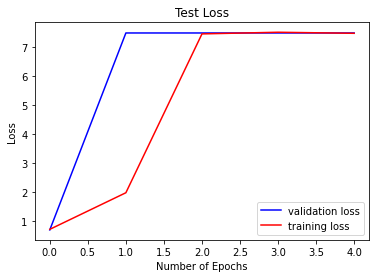

In [19]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="training loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

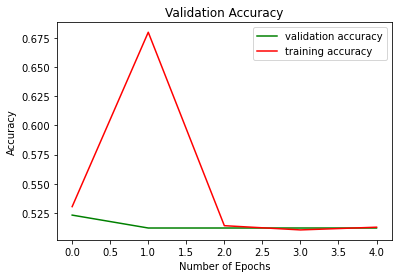

In [20]:
# Plot the accuracy curve for validation 
plt.plot(history.history['val_accuracy'], color='g', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="training accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
model.save('LSTM_weights_2.h5')
model.load_weights('LSTM_weights_2.h5')
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(11588, 2)
(2898, 2)


In [22]:
from keras import metrics
from sklearn.metrics import confusion_matrix
pred = model.predict_classes(x_test)

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
start = time.time() # Measuring the processing time
svm.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)
print('fitting done !!!')

2.0593950748443604
fitting done !!!


In [24]:
Pred_labels = svm.predict(feat_test)
from sklearn.metrics import classification_report
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import xgboost as xgb

xb = xgb.XGBClassifier()
start = time.time() # Measuring the processing time
xb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)
print('fitting done !!!')

0.06318044662475586
fitting done !!!


In [26]:
Pred_labels = xb.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [28]:
lr = LogisticRegression()
start = time.time() # Measuring the processing time
lr.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print('fitting done !!!')

fitting done !!!


In [29]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
dt = DecisionTreeClassifier()
start = time.time() # Measuring the processing time
dt.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.001994609832763672
fitting done !!!
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
knn = KNeighborsClassifier()
start = time.time() # Measuring the processing time
knn.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.10771322250366211
fitting done !!!
              precision    recall  f1-score   support

           0     0.0289    0.2198    0.0512       182
           1     0.9063    0.5059    0.6493      2716

    accuracy                         0.4879      2898
   macro avg     0.4676    0.3628    0.3502      2898
weighted avg     0.8512    0.4879    0.6118      2898



In [32]:
lda = LinearDiscriminantAnalysis()
start = time.time() # Measuring the processing time
lda.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.009016752243041992
fitting done !!!
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
nb = GaussianNB()
start = time.time() # Measuring the processing time
nb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.003981351852416992
fitting done !!!
              precision    recall  f1-score   support

           0     0.9711    0.4941    0.6550      2716
           1     0.0937    0.7802    0.1673       182

    accuracy                         0.5121      2898
   macro avg     0.5324    0.6372    0.4111      2898
weighted avg     0.9160    0.5121    0.6243      2898



In [34]:
et = ExtraTreesClassifier()
start = time.time() # Measuring the processing time
et.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.17690563201904297
fitting done !!!
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


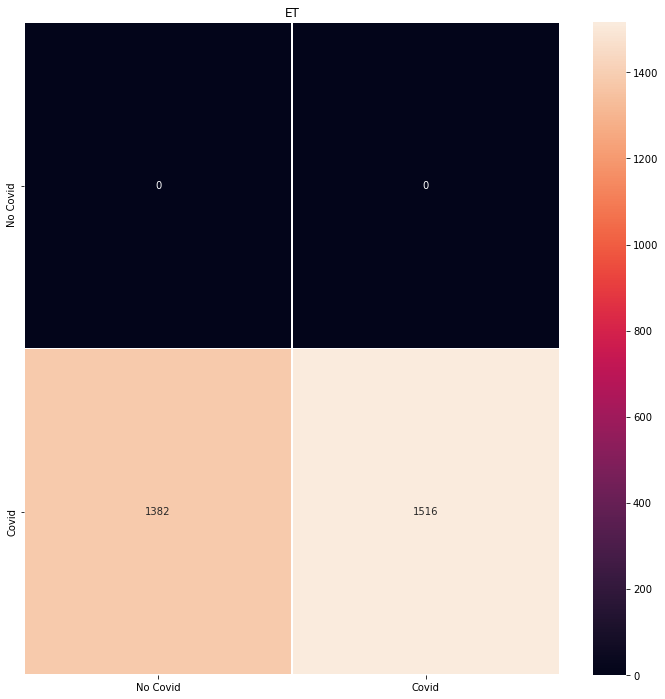

In [35]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'ET')

In [36]:
import lightgbm as lgb
lg = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
start = time.time() # Measuring the processing time
lg.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.03108382225036621
fitting done !!!
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


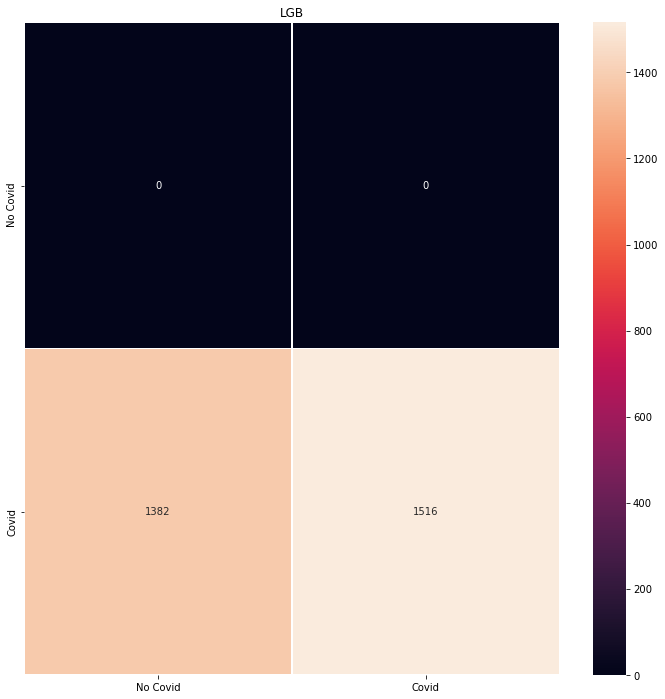

In [37]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LGB')

In [38]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier()
start = time.time() # Measuring the processing time
cb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

Learning rate set to 0.029327
0:	learn: 0.6927484	total: 168ms	remaining: 2m 47s
1:	learn: 0.6923734	total: 172ms	remaining: 1m 25s
2:	learn: 0.6920208	total: 176ms	remaining: 58.6s
3:	learn: 0.6916893	total: 181ms	remaining: 45s
4:	learn: 0.6913777	total: 184ms	remaining: 36.7s
5:	learn: 0.6910847	total: 187ms	remaining: 31s
6:	learn: 0.6908093	total: 190ms	remaining: 27s
7:	learn: 0.6905503	total: 193ms	remaining: 24s
8:	learn: 0.6903069	total: 196ms	remaining: 21.6s
9:	learn: 0.6900781	total: 200ms	remaining: 19.8s
10:	learn: 0.6898629	total: 203ms	remaining: 18.3s
11:	learn: 0.6896607	total: 207ms	remaining: 17s
12:	learn: 0.6894706	total: 210ms	remaining: 15.9s
13:	learn: 0.6892918	total: 213ms	remaining: 15s
14:	learn: 0.6891238	total: 217ms	remaining: 14.2s
15:	learn: 0.6889658	total: 220ms	remaining: 13.5s
16:	learn: 0.6888173	total: 223ms	remaining: 12.9s
17:	learn: 0.6886777	total: 226ms	remaining: 12.4s
18:	learn: 0.6885464	total: 230ms	remaining: 11.9s
19:	learn: 0.6884230	

196:	learn: 0.6864666	total: 834ms	remaining: 3.4s
197:	learn: 0.6864666	total: 837ms	remaining: 3.39s
198:	learn: 0.6864666	total: 840ms	remaining: 3.38s
199:	learn: 0.6864666	total: 843ms	remaining: 3.37s
200:	learn: 0.6864666	total: 847ms	remaining: 3.37s
201:	learn: 0.6864666	total: 851ms	remaining: 3.36s
202:	learn: 0.6864666	total: 853ms	remaining: 3.35s
203:	learn: 0.6864666	total: 855ms	remaining: 3.34s
204:	learn: 0.6864666	total: 858ms	remaining: 3.33s
205:	learn: 0.6864666	total: 863ms	remaining: 3.33s
206:	learn: 0.6864666	total: 866ms	remaining: 3.32s
207:	learn: 0.6864666	total: 868ms	remaining: 3.31s
208:	learn: 0.6864666	total: 870ms	remaining: 3.29s
209:	learn: 0.6864666	total: 873ms	remaining: 3.28s
210:	learn: 0.6864666	total: 878ms	remaining: 3.28s
211:	learn: 0.6864666	total: 880ms	remaining: 3.27s
212:	learn: 0.6864666	total: 883ms	remaining: 3.26s
213:	learn: 0.6864666	total: 885ms	remaining: 3.25s
214:	learn: 0.6864666	total: 888ms	remaining: 3.24s
215:	learn: 0

395:	learn: 0.6864666	total: 1.34s	remaining: 2.04s
396:	learn: 0.6864666	total: 1.34s	remaining: 2.04s
397:	learn: 0.6864666	total: 1.34s	remaining: 2.04s
398:	learn: 0.6864666	total: 1.35s	remaining: 2.03s
399:	learn: 0.6864666	total: 1.35s	remaining: 2.03s
400:	learn: 0.6864666	total: 1.35s	remaining: 2.02s
401:	learn: 0.6864666	total: 1.36s	remaining: 2.02s
402:	learn: 0.6864666	total: 1.36s	remaining: 2.01s
403:	learn: 0.6864666	total: 1.36s	remaining: 2.01s
404:	learn: 0.6864666	total: 1.36s	remaining: 2s
405:	learn: 0.6864666	total: 1.36s	remaining: 2s
406:	learn: 0.6864666	total: 1.37s	remaining: 1.99s
407:	learn: 0.6864666	total: 1.37s	remaining: 1.99s
408:	learn: 0.6864666	total: 1.37s	remaining: 1.98s
409:	learn: 0.6864666	total: 1.38s	remaining: 1.98s
410:	learn: 0.6864666	total: 1.38s	remaining: 1.97s
411:	learn: 0.6864666	total: 1.38s	remaining: 1.97s
412:	learn: 0.6864666	total: 1.38s	remaining: 1.96s
413:	learn: 0.6864666	total: 1.38s	remaining: 1.96s
414:	learn: 0.6864

598:	learn: 0.6864666	total: 1.84s	remaining: 1.23s
599:	learn: 0.6864666	total: 1.84s	remaining: 1.23s
600:	learn: 0.6864666	total: 1.84s	remaining: 1.23s
601:	learn: 0.6864666	total: 1.85s	remaining: 1.22s
602:	learn: 0.6864666	total: 1.85s	remaining: 1.22s
603:	learn: 0.6864666	total: 1.85s	remaining: 1.22s
604:	learn: 0.6864666	total: 1.86s	remaining: 1.21s
605:	learn: 0.6864666	total: 1.86s	remaining: 1.21s
606:	learn: 0.6864666	total: 1.86s	remaining: 1.21s
607:	learn: 0.6864666	total: 1.87s	remaining: 1.2s
608:	learn: 0.6864666	total: 1.87s	remaining: 1.2s
609:	learn: 0.6864666	total: 1.87s	remaining: 1.2s
610:	learn: 0.6864666	total: 1.88s	remaining: 1.19s
611:	learn: 0.6864666	total: 1.88s	remaining: 1.19s
612:	learn: 0.6864666	total: 1.88s	remaining: 1.19s
613:	learn: 0.6864666	total: 1.88s	remaining: 1.18s
614:	learn: 0.6864666	total: 1.89s	remaining: 1.18s
615:	learn: 0.6864666	total: 1.89s	remaining: 1.18s
616:	learn: 0.6864666	total: 1.89s	remaining: 1.18s
617:	learn: 0.6

803:	learn: 0.6864666	total: 2.35s	remaining: 572ms
804:	learn: 0.6864666	total: 2.35s	remaining: 569ms
805:	learn: 0.6864666	total: 2.35s	remaining: 566ms
806:	learn: 0.6864666	total: 2.35s	remaining: 563ms
807:	learn: 0.6864666	total: 2.36s	remaining: 560ms
808:	learn: 0.6864666	total: 2.36s	remaining: 557ms
809:	learn: 0.6864666	total: 2.36s	remaining: 554ms
810:	learn: 0.6864666	total: 2.36s	remaining: 551ms
811:	learn: 0.6864666	total: 2.37s	remaining: 548ms
812:	learn: 0.6864666	total: 2.37s	remaining: 545ms
813:	learn: 0.6864666	total: 2.37s	remaining: 542ms
814:	learn: 0.6864666	total: 2.37s	remaining: 539ms
815:	learn: 0.6864666	total: 2.38s	remaining: 536ms
816:	learn: 0.6864666	total: 2.38s	remaining: 533ms
817:	learn: 0.6864666	total: 2.38s	remaining: 530ms
818:	learn: 0.6864666	total: 2.38s	remaining: 527ms
819:	learn: 0.6864666	total: 2.38s	remaining: 524ms
820:	learn: 0.6864666	total: 2.39s	remaining: 520ms
821:	learn: 0.6864666	total: 2.39s	remaining: 517ms
822:	learn: 

995:	learn: 0.6864666	total: 2.84s	remaining: 11.4ms
996:	learn: 0.6864666	total: 2.85s	remaining: 8.56ms
997:	learn: 0.6864666	total: 2.85s	remaining: 5.71ms
998:	learn: 0.6864666	total: 2.85s	remaining: 2.85ms
999:	learn: 0.6864666	total: 2.85s	remaining: 0us
3.4983630180358887
fitting done !!!
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


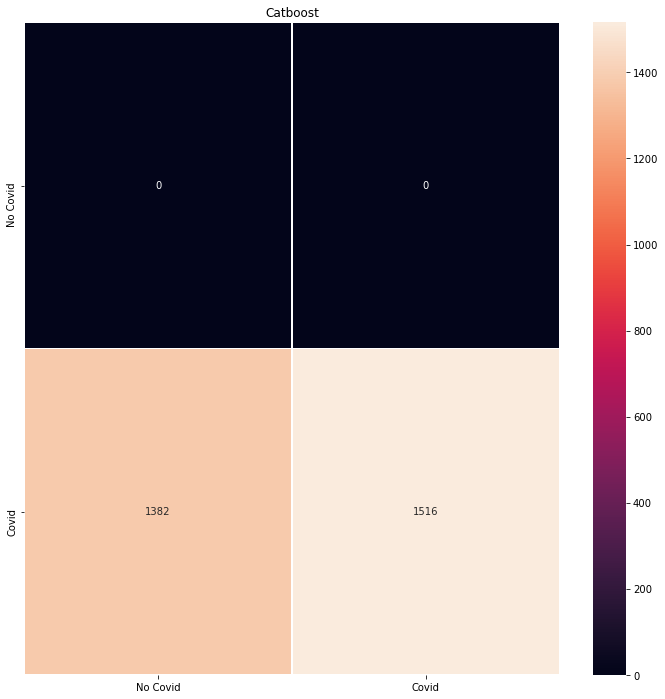

In [39]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'Catboost')

In [40]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [41]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
ensemble.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5231    0.6869      2898

    accuracy                         0.5231      2898
   macro avg     0.5000    0.2616    0.3435      2898
weighted avg     1.0000    0.5231    0.6869      2898



C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


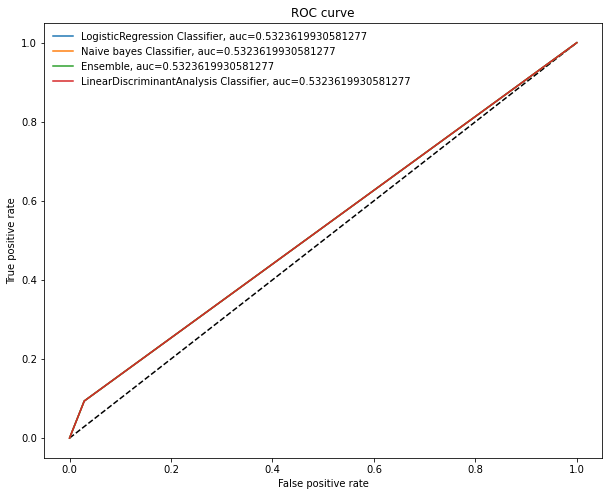

In [42]:
from sklearn import metrics
from sklearn.metrics import roc_curve


clf2=LogisticRegression().fit(feat_train,np.argmax(y_train,axis=1))
y_pred2 = clf2.predict(feat_test)

clf3 = GaussianNB().fit(feat_train,np.argmax(y_train,axis=1))
y_pred3 = clf3.predict(feat_test)

clf4 = ensemble.fit(feat_train,np.argmax(y_train,axis=1))
y_pred4 = clf4.predict(feat_test)

clf6=LinearDiscriminantAnalysis().fit(feat_train,np.argmax(y_train,axis=1))
y_pred6 = clf6.predict(feat_test)

#clf7=SVC(kernel='rbf').fit(feat_train,np.argmax(y_train,axis=1))
#y_pred7 = clf7.predict(feat_test)

y_pred_proba2 = clf2.predict_proba(feat_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba2)
auc2 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba2)

y_pred_proba3 = clf3.predict_proba(feat_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba3)
auc3 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba3)

y_pred_proba4 = clf4.predict_proba(feat_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba4)
auc4 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba4)

y_pred_proba6 = clf6.predict_proba(feat_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba6)
auc6 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba6)

#y_pred_proba7 = clf7.predict_proba(feat_test)[::,1]
#fpr7, tpr7, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba7)
#auc7 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba7)


plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2,tpr2,label="LogisticRegression Classifier, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Naive bayes Classifier, auc="+str(auc3))
plt.plot(fpr4,tpr4,label="Ensemble, auc="+str(auc4))
plt.plot(fpr6,tpr6,label="LinearDiscriminantAnalysis Classifier, auc="+str(auc6))
#plt.plot(fpr7,tpr7,label="SVC Classifier, auc="+str(auc7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(frameon=False)
plt.show()